# Physics-Informed Neural Networks (PINNs)

A PINN is a Neural Network that is loss function is computed using the differential equation we are trying to solve.
To demonstrate the method, we will consider the heat conduction equation in a two-dimensional domain $\Omega  \subset \Re^2$ with boundary $\partial\Omega$. <br />
The boundary is comprised by points where Dirichlet and Neumann boundary conditions are applied, which are denoted as $\partial\Omega_D$ and $\partial\Omega_N$, respectively. <br />
The heat conduction equation with its respective boundary and initial conditions is written as follows

* $\frac{\partial}{\partial t} T(\vec{x}, t) = \alpha \Delta T(\vec{x}, t) + \frac{1}{\rho c_p}q'''(\vec{x}, t), \;\;\; \vec{x} \in \Omega, t \in [0, T]$
* $T(\vec{x}, t) = g_D(t),  \;\;\;\;\;  \vec{x} \in \partial\Omega_D, t \in (0, T]$
* $\frac{\partial}{\partial \vec{n}}T(\vec{x}, t) = g_N(t),  \;\;\;\;\;  \vec{x} \in \partial\Omega_N, t \in (0, T]$
* $T(\vec{x}, 0) = h(\vec{x}), \;\;\;\;\; \vec{x} \in \Omega$


The following figure displays the diagram of a PINN: <br />

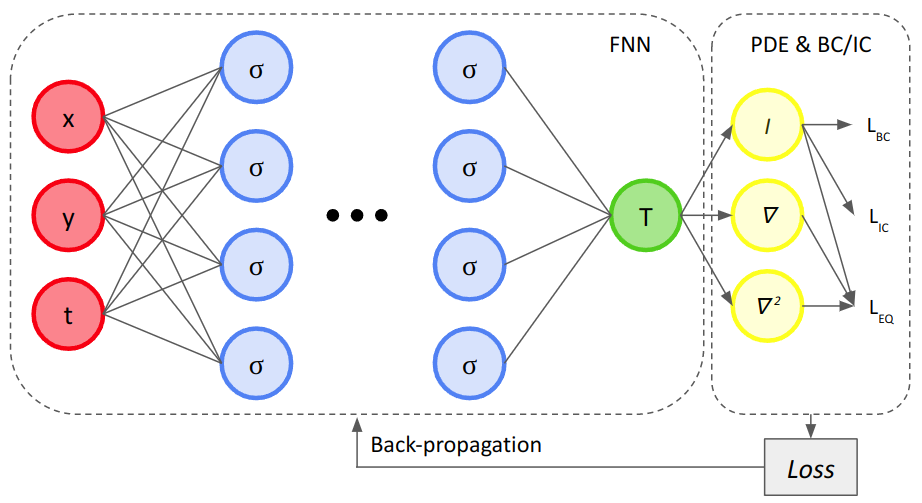

The solution of the heat conduction equation is the temperature field $T(\vec{x}, t)$ which can be approximated by the PINN. <br />
The independent variables $x$, $y$, and $t$ work as input, and a value for $T$ as the output. <br />
The training of the network defines the weights and biases by minimizing the loss function which conforms the PDE: <br />

* $L = L_{EQ} + L_{BC} + L_{IC}$
* $L_{EQ} = \frac{1}{N_{EQ}} \sum_i \left| f(\vec{x}^i, t^i) \right|^2   \;\;\;\;\;  \vec{x}^i \in \Omega, t^i \in [0, T]$
* $f(\vec{x}, t) = \frac{\partial}{\partial t} T(\vec{x}, t) - \alpha \Delta T(\vec{x}, t) - \frac{1}{\rho c_p}q'''(\vec{x}, t)$
* $L_{BC} = L_{BC, D} + L_{BC, N}$
* $L_{BC, D} = \frac{1}{N_{BC, D}} \sum_i \left| T(\vec{x}^i, t^i) - g_D(t^i) \right|^2   \;\;\;\;\;  \vec{x}^i \in \partial\Omega_D, t^i \in (0, T]$
* $L_{BC, N} = \frac{1}{N_{BC, N}} \sum_i \left| \frac{\partial}{\partial \vec{n}}T(\vec{x}^i, t^i) - g_N(t^i) \right|^2   \;\;\;\;\;  \vec{x}^i \in \partial\Omega_N, t^i \in (0, T]$
* $L_{IC} = \frac{1}{N_{IC}} \sum_i \left| T(\vec{x}^i, 0) - h(\vec{x}^i) \right|^2    \;\;\;\;\;  \vec{x}^i \in \Omega$

where $L_{EQ}$ is the loss of the equation residuals, $L_{BC}$ is the loss of the boundary conditions residuals, separated into dirichlet $L_{BC, D}$ and neumann $L_{BC, N}$ conditions, and $L_{IC}$ is the loss of the inicial condition residuals. <br />
$N_{EQ}$, $N_{BC, D}$, $N_{BC, N}$, and $N_{IC}$ are the numbers of data points for the different terms.

# Example: Solving the Heat Conduction Equation in a complex geometry

The points of the geometry are created with [gmsh](https://gmsh.info/).

In [18]:
import gmsh
import numpy as np
np.random.seed(1234)


def get_points_2D(mesh_file):
    """
    Parameters:
        mesh_file: (str) name of file containing the mesh definition. GMSH mesh format: 4.1 0 8.
    Returns:
        X_domain: numpy (Nx*Ny, 3) matrix. 3rd column contains info in Z, it can be ignored as we are working on 2D for now.
        X_bc: (dict), keys: boundaries, values: points in boundary
    """
    gmsh.initialize()
    gmsh.open(mesh_file)

    points = []
    node_tags_1D = {}
    node_tags_2D = {}
    adjacencies = {}

    model_dimension = gmsh.model.getDimension()
    entities = gmsh.model.getEntities()
    for e in entities:
        # Dimension and tag of the entity:
        dim = e[0]
        tag = e[1]

        # Physical groups
        physicalTags = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
        nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes(dim, tag)
        elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim, tag)

        for i in range(0, len(nodeCoords), 3):
            points.append([nodeCoords[i], nodeCoords[i+1], nodeCoords[i+2]])

        _, down = gmsh.model.getAdjacencies(e[0], e[1])

        if len(physicalTags):
            s = ''
            for p in physicalTags:
                n = gmsh.model.getPhysicalName(dim, p)
            print(f'Physical group: {n}')
            print(nodeTags)

            # NS would need dim 0 for pressure
            if dim == 1:
                node_tags_1D[n] = nodeTags
            elif dim == 2:
                node_tags_2D[n] = nodeTags

            if len(down):
                adjacencies[n] = down

    gmsh.clear()
    gmsh.finalize()

    points = np.array(points)
    for k, tags in node_tags_1D.items():
        adja = adjacencies[k]
        node_tags_1D[k] = np.concatenate((tags, adja), dtype=int)

    # uncomment this to include the boundary points into the evaluation points
    # for k, _ in node_tags_2D.items():
    #     adja = adjacencies[k] - 1
    #     for i, tags2 in enumerate(node_tags_1D.values()):
    #         if i in adja:
    #             node_tags_2D[k] = np.concatenate((node_tags_2D[k], tags2)) 
    #     node_tags_2D[k] = np.unique(node_tags_2D[k])  # remove duplicates
    #     node_tags_2D[k] = np.array(node_tags_2D[k], dtype=int)
    # print(node_tags_2D)

    # Domain
    get_tags = node_tags_2D['region1'] - 1
    X_domain = points[get_tags]

    # BCs
    X_bc = {}
    for k, tags in node_tags_1D.items():
        X_bc[k] = points[tags - 1]

    # Points in X_bc are not included in X_domain
    return X_domain, X_bc

The following lines define the NN and the conforming of the heat equation.

In [22]:
import torch
from collections import OrderedDict


device = torch.device('cpu')

# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [23]:
# constants
k = 1
q = 10

# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_f, X_u_dir, X_u_neu, u_dir, q_neu, theta_neu, layers):

        # domain
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.y_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        
        # bc: dir
        self.x_u_dir = torch.tensor(X_u_dir[:, 0:1], requires_grad=True).float().to(device)
        self.y_u_dir = torch.tensor(X_u_dir[:, 1:2], requires_grad=True).float().to(device)
        self.u_dir = torch.tensor(u_dir).float().to(device)

        # bc: neu
        self.x_u_neu = torch.tensor(X_u_neu[:, 0:1], requires_grad=True).float().to(device)
        self.y_u_neu = torch.tensor(X_u_neu[:, 1:2], requires_grad=True).float().to(device)
        self.q_neu = torch.tensor(q_neu).float().to(device)
        self.theta = torch.tensor(theta_neu).float().to(device)

        # deep neural networks
        self.dnn = DNN(layers).to(device)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0

    def net_u(self, x, y):  
        u = self.dnn(torch.cat([x, y], dim=1))
        return u

    def net_f(self, x, y):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, y)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        f = u_xx + u_yy + q
        return f

    def loss_func(self):
        self.optimizer.zero_grad()

        f_pred = self.net_f(self.x_f, self.y_f)
        loss_f = torch.mean(f_pred ** 2)

        u_pred = self.net_u(self.x_u_dir, self.y_u_dir)
        loss_u_dir = torch.mean((self.u_dir - u_pred) ** 2)

        uh = self.net_u(self.x_u_neu, self.y_u_neu)
        uh_x = torch.autograd.grad(uh, self.x_u_neu, grad_outputs=torch.ones_like(uh), retain_graph=True, create_graph=True)[0]
        uh_y = torch.autograd.grad(uh, self.y_u_neu, grad_outputs=torch.ones_like(uh), retain_graph=True, create_graph=True)[0]
        uh_n = uh_x * -torch.sin(self.theta/180.*np.pi) + uh_y * torch.cos(self.theta/180.*np.pi)
        qh = -k * uh_n
        loss_u_neu = torch.mean((self.q_neu - qh) ** 2)

        loss = 1e-2*loss_f + loss_u_dir + loss_u_neu
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                f'Iter {self.iter}, '
                f'Loss: {loss.item():.5e}, '
                f'Loss_f: {loss_f.item():.5e}, '
                f'Loss_u_dir: {loss_u_dir.item():.5e}, '
                f'Loss_u_neu: {loss_u_neu.item():.5e}'
            )
        return loss

    def train(self):
        self.dnn.train()

        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        y = torch.tensor(X[:, 1:2], requires_grad=True).float()
        u = self.net_u(x, y)

        u = u.detach().numpy()
        return u

In [11]:
# we get the evaluation and boundary points
X_eval, X_bc_dict = get_points_2D('2D-complex.msh')
print(X_eval.shape, X_bc_dict)

Info    : Reading '2D-complex.msh'...
Info    : 13 entities
Info    : 3397 nodes
Info    : 6792 elements
Info    : Done reading '2D-complex.msh'
Physical group: line1
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59]
Physical group: line2
[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85]
Physical group: line3
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114]
Physical group: line4
[115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159]
Physical group: line5
[160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190]
Physical group: line6
[191 192 193 194 195 196 197 198 199 200 201 202 

In [12]:
# we calculate angles between boundary lines manually
def calc_angle(vector_1, vector_2):
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle/np.pi * 180

x1 = np.array([0.4, 0])
x2 = np.array([0, 1])
x3 = np.array([0.5, 1.2])
x4 = np.array([0.8, 0.7])
x5 = np.array([1.7, 0.8])
x6 = np.array([1.5, 0.2])

# curve1
vector_1 = x2 - x1
vector_2 = np.array([1., 0])
print(calc_angle(vector_1, vector_2))

# curve6
vector_1 = x1 - x6
vector_2 = np.array([1., 0])
print(calc_angle(vector_1, vector_2))

111.8014094863518
169.695153531234


In [13]:
# get X_dom, X_neu, T_neu, theta
train_portion = 0.4
N_train = int(X_eval.shape[0] * train_portion)
idx = np.random.choice(X_eval.shape[0], N_train, replace=False)
X_dom = X_eval[idx, :]

print(X_eval.shape)
print(X_dom.shape)

train_portion = 1.0
X_bc_train = {}
for key, points in X_bc_dict.items():
    N_train = int(points.shape[0]* train_portion)
    idx = np.random.choice(points.shape[0], N_train, replace=False)
    X_bc_train[key] = points[idx, :]


X_dom = X_dom[:, 0:2]
print(X_dom)

# BCs  
boundary = 'line2'
X_bc_i = X_bc_train[boundary][:, 0:2]
T_bc_i = np.zeros_like(X_bc_i[:, 0:1])
X_dir = X_bc_i
T_dir = T_bc_i

boundaries = ['line3', 'line4', 'line5']
for boundary in boundaries:
    X_bc_i = X_bc_train[boundary][:, 0:2]
    T_bc_i = np.zeros_like(X_bc_i[:, 0:1])
    X_dir = np.vstack((X_dir, X_bc_i))
    T_dir = np.vstack((T_dir, T_bc_i))

boundary = 'line1'
angle = 111.8014
X_bc_i = X_bc_train[boundary][:, 0:2]
T_bc_i = np.zeros_like(X_bc_i[:, 0:1])
theta_i = np.ones_like(X_bc_i[:, 0:1]) * angle
X_neu = X_bc_i
T_neu = T_bc_i
theta = theta_i

boundary = 'line6'
angle = -169.69515
X_bc_i = X_bc_train[boundary][:, 0:2]
T_bc_i = np.zeros_like(X_bc_i[:, 0:1])
theta_i = np.ones_like(X_bc_i[:, 0:1]) * angle
X_neu = np.vstack((X_neu, X_bc_i))
T_neu = np.vstack((T_neu, T_bc_i))
theta = np.vstack((theta, theta_i))

(3152, 3)
(1260, 3)
[[0.91399408 0.58495678]
 [1.38316403 0.33649801]
 [0.81130945 0.15414717]
 ...
 [1.31284741 0.38663362]
 [0.62202486 0.2022255 ]
 [1.09246139 0.51974205]]


In [24]:
layers = [2, 30, 30, 30, 1]  # these numbers were not optimized
model = PhysicsInformedNN(X_dom, X_dir, X_neu, T_dir, T_neu, theta, layers)
model.train()

Iter 100, Loss: 1.44258e-01, Loss_f: 4.90641e+00, Loss_u_dir: 7.52060e-02, Loss_u_neu: 1.99875e-02
Iter 200, Loss: 2.96260e-02, Loss_f: 1.25208e+00, Loss_u_dir: 1.46773e-02, Loss_u_neu: 2.42789e-03
Iter 300, Loss: 1.48750e-02, Loss_f: 4.49885e-01, Loss_u_dir: 1.00880e-02, Loss_u_neu: 2.88228e-04
Iter 400, Loss: 9.54673e-03, Loss_f: 2.68588e-01, Loss_u_dir: 6.33380e-03, Loss_u_neu: 5.27054e-04
Iter 500, Loss: 7.28986e-03, Loss_f: 1.96193e-01, Loss_u_dir: 5.10302e-03, Loss_u_neu: 2.24909e-04
Iter 600, Loss: 5.38524e-03, Loss_f: 1.38612e-01, Loss_u_dir: 3.76537e-03, Loss_u_neu: 2.33756e-04
Iter 700, Loss: 4.32203e-03, Loss_f: 9.69131e-02, Loss_u_dir: 3.24083e-03, Loss_u_neu: 1.12065e-04
Iter 800, Loss: 3.77728e-03, Loss_f: 7.48019e-02, Loss_u_dir: 2.93550e-03, Loss_u_neu: 9.37615e-05
Iter 900, Loss: 3.23065e-03, Loss_f: 7.18864e-02, Loss_u_dir: 2.43464e-03, Loss_u_neu: 7.71395e-05
Iter 1000, Loss: 2.75152e-03, Loss_f: 5.90469e-02, Loss_u_dir: 2.09304e-03, Loss_u_neu: 6.80060e-05
Iter 1100

In [31]:
X_bc_dict.keys()

dict_keys(['line1', 'line2', 'line3', 'line4', 'line5', 'line6'])

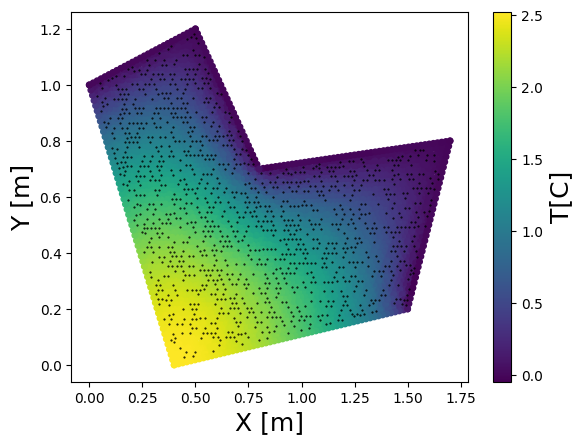

In [34]:
# plot Temperature ditribution
import matplotlib.pyplot as plt


# add BC points and Eval points together
for i, points in enumerate(X_bc_dict.values()):
    if i == 0:
        X_all = X_eval.copy()
    X_all = np.concatenate((X_all, points))


# temperature field
U_pred = model.predict(X_all)

# Evaluation points
x = X_all[:, 0]
y = X_all[:, 1]
z = U_pred[:, 0]

fig, ax = plt.subplots()
plt.scatter(x, y, c=z, cmap='viridis', s=16)
cbar = plt.colorbar()
cbar.set_label('T[C]', fontsize=18)

# Training points
x = X_dom[:, 0]
y = X_dom[:, 1]
ax.plot(x, y, 'ko', ms=0.5)

plt.subplots_adjust(hspace=0.5)
plt.xlabel('X [m]', fontsize=18)
plt.ylabel('Y [m]', fontsize=18)

figname = '2D-complex-neumann'
plt.savefig(figname, dpi=300, bbox_inches="tight", facecolor='white')